# Reccurent Neural Network

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from tqdm import tqdm
import yfinance as yf
import pickle
import datetime

## Import Financial Data

In [2]:
msft = yf.Ticker("MSFT")
hist = msft.history(period='max')
BTC = yf.Ticker("BTC")
hist = BTC.history(period='max')

## Data Loader for Stock/Crypto Price Data
 - Take daily price data
 - Can also add high/low/volume?

In [6]:
# Select random windows from time series data

def getwindows(dataX, dataY, windowsize, trainsplit):
	N = len(dataX)
	nwindows = int(N/windowsize)
	ntrain = int(trainsplit*nwindows)

	starts = np.arange(nwindows)*windowsize
	np.random.shuffle(starts)
	trainpos = starts[:ntrain]
	valpos = starts[ntrain:]

	trainwindows = []
	traintarget = []
	valwindows = []
	valtarget = []
	for idx in trainpos:
		trainwindows.append(dataX[idx:idx+windowsize])
		traintarget.append(dataY[idx:idx+windowsize])
	for idx in valpos:
		valwindows.append(dataX[idx:idx+windowsize])
		valtarget.append(dataY[idx:idx+windowsize])

	return np.array(trainwindows), np.array(traintarget), trainpos, np.array(valwindows), np.array(valtarget), valpos

x = np.random.rand(2000,10)
y = np.random.rand(2000,5)

tx, ty, tpos, vx, vy, vpos = getwindows(x, y, 100, .80)
print(tx.shape)
print(ty.shape)
print(vx.shape)
print(vy.shape)

(16, 100, 10)
(16, 100, 5)
(4, 100, 10)
(4, 100, 5)


In [7]:
class StockCryptoDataset(Dataset):
    def __init__(self, dataX, dataY, datapos):
        self.trainX = dataX
        self.trainY = dataY
        self.pos = datapos

    def __len__(self):
        return len(self.trainX)

    def __getitem__(self, idx):
        return self.trainX[idx], self.trainY[idx], self.pos[idx]

In [ ]:
# load stock-crypto npy data
stocks = np.load("./stocks.npy")
cryptos = np.load("./cryptos.npy")

print(stocks.shape)
print(cryptos.shape)
# Rescale each stock and crypto
print(stocks[0][:5])
for i, c in enumerate(stocks):
	c = c/np.max(c)
	stocks[i] = c
	break
print(stocks[0][:5])
print(cryptos[0][:5])
for i, c in enumerate(cryptos):
	c = c/np.max(c)
	cryptos[i] = c
	break
print(cryptos[0][:5])
# print(cryptos[:8])
# print(len(np.divide(cryptos, np.max(cryptos, axis=1))))
# print((np.divide(cryptos, np.max(cryptos, axis=1)))[:8])


stocks = stocks.transpose()
cryptos = cryptos.transpose()

(440, 1115)
(8, 1115)
[58.09891891 57.53467941 56.96118164 56.79467773 56.97042847]
[0.68229444 0.6756682  0.66893323 0.66697787 0.66904183]
[ 99.0037   104.236    102.397003 100.351997  98.292397]
[0.26233874 0.27620322 0.27133027 0.26591144 0.26045394]


: 

## Recurrent Neural Network

cpu
(1115, 440)
(1115, 8)
[0.68229444 0.6822944  0.37060647 0.44880663 0.33273223]
[0.26233874 0.00313679 0.09695169 0.16244065 0.0442525 ]


100%|██████████| 30/30 [01:07<00:00,  2.25s/it]


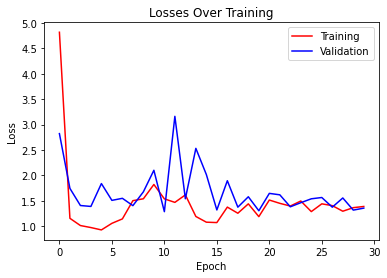

(5, 1, 440)
(5, 1, 8)
(5, 1, 8)
[0.11981259]
[0.15833768]


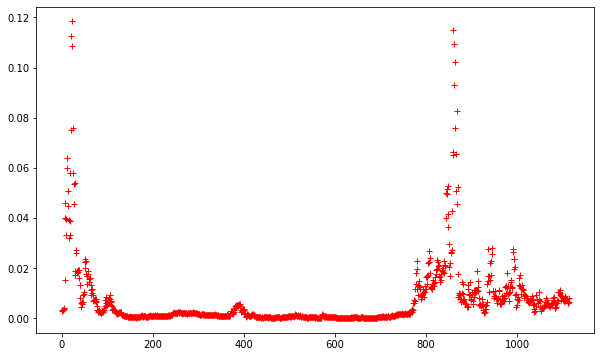

(440, 1115)


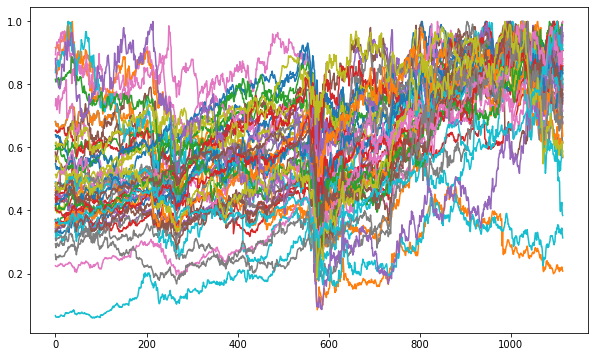

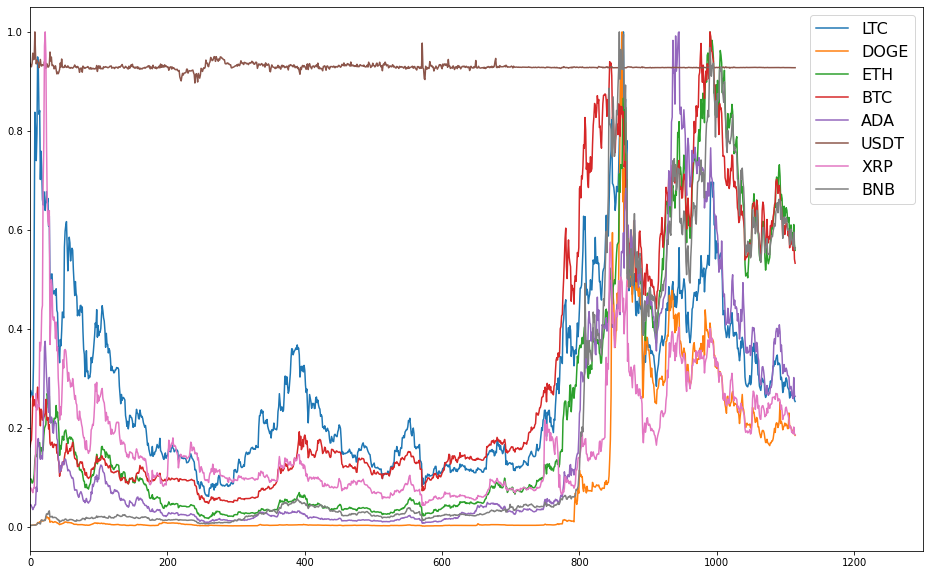

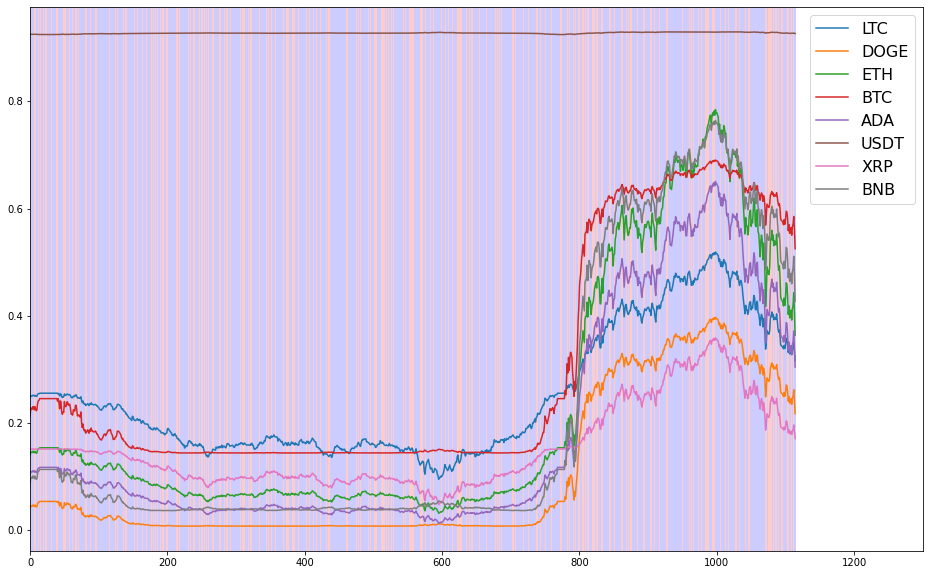

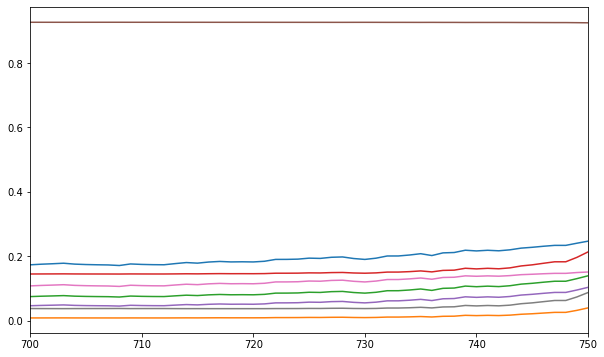

In [133]:
if torch.cuda.is_available():
	DEVICE= torch.device('cuda')
else:   
	DEVICE = torch.device('cpu')
print(DEVICE)

class FinCryptoRNN(nn.Module):
	def __init__(self, n_companies, n_crypto, l_window):
		super(FinCryptoRNN, self).__init__()
		self.n_companies = n_companies
		self.n_crypto = n_crypto

		self.hidden1 = 1000
		self.hidden2 = 1000
		self.hidden3 = 50

		self.rnn1 = nn.RNN(n_companies, self.hidden1, nonlinearity='relu', batch_first=True)
		self.rnn2 = nn.RNN(self.hidden1, self.hidden2, nonlinearity='tanh', batch_first=True)
		self.rnn3 = nn.RNN(self.hidden2, self.hidden3, nonlinearity='tanh', batch_first=True)

		self.drop1 = nn.Dropout(p=0.2)
		self.drop2 = nn.Dropout(p=0.2)
		self.FC = nn.Linear(self.hidden3*l_window, n_crypto*l_window)

		self.relu = nn.ReLU()
		
	def forward(self, x):
		x, hout = self.rnn1(x)
		x = self.drop1(x)
		x, hout = self.rnn2(x)
		x = self.drop2(x)
		x, hout = self.rnn3(x)

		# Take final RNN output and feed to Fully Connected Layers
		x = torch.flatten(x, start_dim=1)
		x = self.FC(x)
		x = torch.reshape(x, (-1, l_window, self.n_crypto))
		# x = self.relu(x)
		return x
		
# Generate random data
# x = np.random.rand(5000,200)
# y = np.random.rand(5000,10)

# Generate sinusoidal data
# x = np.array([np.sin(np.linspace(0,10,5000)*233)])
# x = np.repeat(x, 440, axis=0)
# x = np.transpose(x)

# y = np.array([np.cos(np.linspace(0,10,5000)*233)])
# y = np.repeat(y, 8, axis=0)
# y = np.transpose(y)
# print('datashape', x.shape)
# print('datashape', y.shape)

# l_window = 23
# tx, ty, vx, vy = getwindows(x, y, l_window, .80)

# load stock-crypto npy data
stocks = np.load("./stocks.npy")
cryptos = np.load("./cryptos.npy")
# Rescale each stock and crypto
for i, c in enumerate(stocks):
	c = c/np.max(c)
	stocks[i] = c

for i, c in enumerate(cryptos):
	c = c/np.max(c)
	cryptos[i] = c

stocks = stocks.transpose()
cryptos = cryptos.transpose()
print(stocks.shape)
print(cryptos.shape)
print(stocks[0][:5])
print(cryptos[0][:5])

l_window = 1
tx, ty, tpos, vx, vy, vpos = getwindows(stocks, cryptos, l_window, .70)

traindataset = StockCryptoDataset(tx, ty, tpos)
valdataset = StockCryptoDataset(vx, vy, vpos)

trainloader = DataLoader(traindataset, batch_size=10, shuffle=True)
valloader = DataLoader(valdataset, batch_size=10, shuffle=True)

model = FinCryptoRNN(n_companies=440, n_crypto=8, l_window=l_window).float()

mseloss = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

NEPOCHS = 30

tlosses = []
vlosses = []
for i in tqdm(range(NEPOCHS)):
	model.train()
	loss_i = 0
	for stock, crypto, time in trainloader:
		stock = stock.float()
		crypto = crypto.float()
		outputs = model(stock)

		loss = mseloss(outputs, crypto)
		loss_i += loss.item()
		loss.backward()

		optimizer.step()
		optimizer.zero_grad()
	tlosses.append(loss_i/.8)
	# print("\r Loss", loss_i, end='')
	
	model.eval()
	loss_i = 0
	for stock, crypto, time in valloader:
		stock = stock.float()
		crypto = crypto.float()
		outputs = model(stock)

		loss = mseloss(outputs, crypto)
		loss_i += loss.item()
	vlosses.append(loss_i/.2)

plt.figure()
plt.title("Losses Over Training")
plt.plot(tlosses, 'r-', label='Training')
plt.plot(vlosses, 'b-', label='Validation')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

stock = stock.numpy()
crypto = crypto.numpy()
outputs = outputs.detach().numpy()

print(stock.shape)
print(crypto.shape)
print(outputs.shape)
print(crypto[0,:,0])
print(outputs[0,:,0])

# Evaluate model performance over time
model.eval()

losses = []
times = []
valp = []
trainp = []
targets = None
preds = None
inputs = None
for i, (stock, crypto, time) in enumerate(valloader):
	stock = stock.float()
	crypto = crypto.float()
	outputs = model(stock)
	if i==0:
		inputs = stock.numpy()
		targets = crypto.numpy()
		preds = outputs.detach().numpy()
	else:
		inputs = np.concatenate((inputs, stock.numpy()))
		targets = np.concatenate((targets, crypto.numpy()))
		preds = np.concatenate((preds, outputs.detach().numpy()))

	# calculate loss for each window
	for i in range(len(stock)):
		loss = mseloss(outputs[i], crypto[i])
		losses.append(loss.item())
		times.append(time[i])
		valp.append(time[i])

for stock, crypto, time in trainloader:
	stock = stock.float()
	crypto = crypto.float()
	outputs = model(stock)

	inputs = np.concatenate((inputs, stock.numpy()))
	targets = np.concatenate((targets, crypto.numpy()))
	preds = np.concatenate((preds, outputs.detach().numpy()))
	# calculate loss for each window
	for i in range(len(stock)):
		loss = mseloss(outputs[i], crypto[i])
		losses.append(loss.item())
		times.append(time[i])
		trainp.append(time[i])

# print(losses)
# print(time)
plt.figure(figsize=(10,6))
plt.plot(times,losses, "r+")
plt.show()

# sort by window times
# targets_t = sorted(targets, key=times)
inputs_t = [x for _, x in sorted(zip(times, inputs))]
inputs_t = np.concatenate(inputs_t)
inputs_t = np.transpose(inputs_t)
targets_t = [x for _, x in sorted(zip(times, targets))]
targets_t = np.concatenate(targets_t)
preds_t = [x for _, x in sorted(zip(times, preds))]
preds_t = np.concatenate(preds_t)

print(inputs_t.shape)

plt.figure(figsize=(10,6))
for i in range(50):
	plt.plot(inputs_t[i])
plt.show()

cr_names = ["LTC", "DOGE", "ETH", "BTC", "ADA","USDT", "XRP", "BNB"]
plt.figure(figsize=(16,10))
plt.plot(targets_t, label=cr_names)
plt.xlim(0, 1300)
plt.legend(fontsize=16)
plt.show()

plt.figure(figsize=(16,10))
plt.plot(preds_t, label=cr_names)
# train/val windows
for t in valp:
	plt.axvspan(t, t+l_window, facecolor="red", alpha=0.2)
for t in trainp:
	plt.axvspan(t, t+l_window, facecolor="blue", alpha=0.2)
plt.xlim(0, 1300)
plt.legend(fontsize=16)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(preds_t)
plt.xlim(700,750)
plt.show()

['2017-12-01', '2017-12-04', '2017-12-05', '2017-12-06', '2017-12-07']
2017-12-01 00:00:00


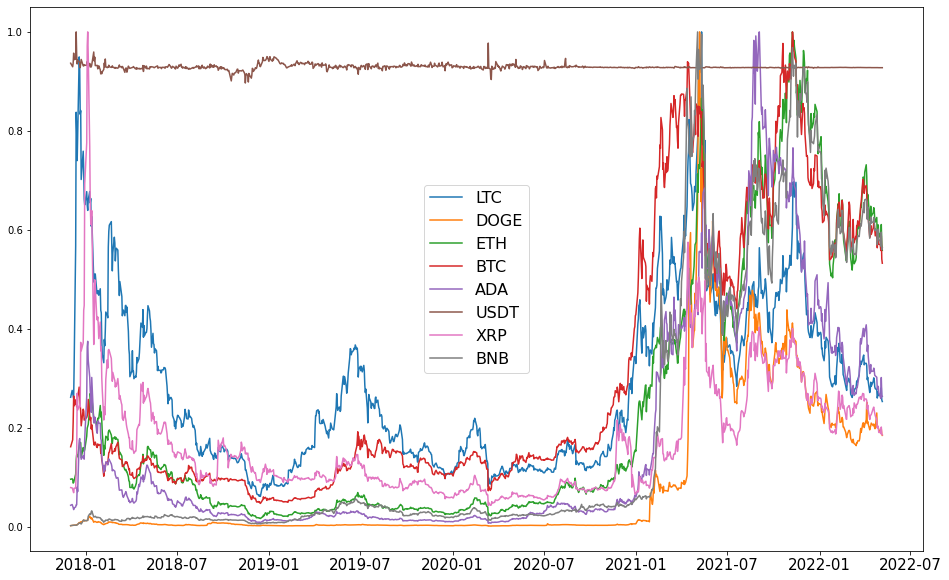

In [131]:
with open("dates.p", 'rb') as pfile:
	dates = pickle.load(pfile)

print(dates[:5])
dts = []
for d in dates:
	vals = [int(i) for i in d.split("-")]
	dts.append(datetime.datetime(vals[0], vals[1], vals[2]))

print(dts[0])

cr_names = ["LTC", "DOGE", "ETH", "BTC", "ADA","USDT", "XRP", "BNB"]
plt.figure(figsize=(16,10))
plt.plot_date(dts, targets_t, "-",label=cr_names)
plt.xticks(fontsize=15)
# plt.xlim(0, 1300)
plt.legend(fontsize=16)
plt.show()

In [54]:
for idx, p in enumerate(model.parameters()):
	print(idx, p.shape)
	param = p
	break

param = param.detach().numpy()

strength = np.sum(np.abs(param), axis=0)
print(strength.shape)
plt.figure()
plt.title("Individual Stock Importance")
plt.hist(strength)
plt.xlabel("Stock Importance")
plt.show()

0 torch.Size([500, 440])
1 torch.Size([500, 500])
2 torch.Size([500])
3 torch.Size([500])
4 torch.Size([300, 500])
5 torch.Size([300, 300])
6 torch.Size([300])
7 torch.Size([300])
8 torch.Size([50, 300])
9 torch.Size([50, 50])
10 torch.Size([50])
11 torch.Size([50])
12 torch.Size([64, 400])
13 torch.Size([64])


0 torch.Size([500, 440])
1 torch.Size([500, 500])
2 torch.Size([500])
3 torch.Size([500])
4 torch.Size([300, 500])
5 torch.Size([300, 300])
6 torch.Size([300])
7 torch.Size([300])
8 torch.Size([50, 300])
9 torch.Size([50, 50])
10 torch.Size([50])
11 torch.Size([50])
12 torch.Size([64, 400])
(400,)


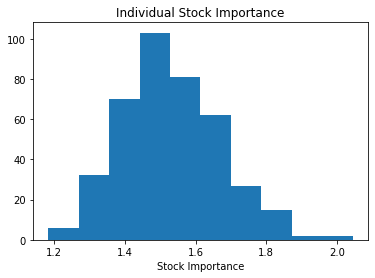

In [55]:
for idx, p in enumerate(model.parameters()):
	print(idx, p.shape)
	param = p
	if idx==12:
		break

param = param.detach().numpy()

strength = np.sum(np.abs(param), axis=0)
print(strength.shape)
plt.figure()
plt.title("Individual Stock Importance")
plt.hist(strength)
plt.xlabel("Stock Importance")
plt.show()

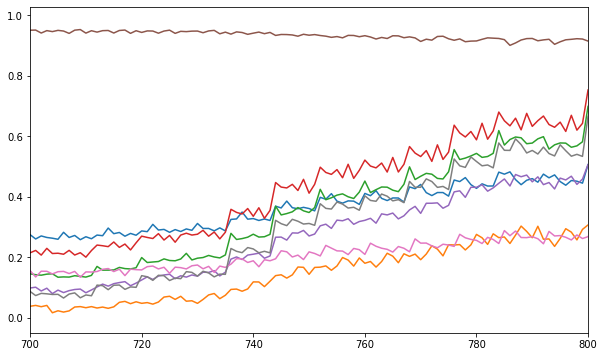

In [96]:
plt.figure(figsize=(10,6))
plt.plot(preds_t)
plt.xlim(700,800)
plt.show()

In [72]:
len(preds[0][0])

8

(1115, 8)


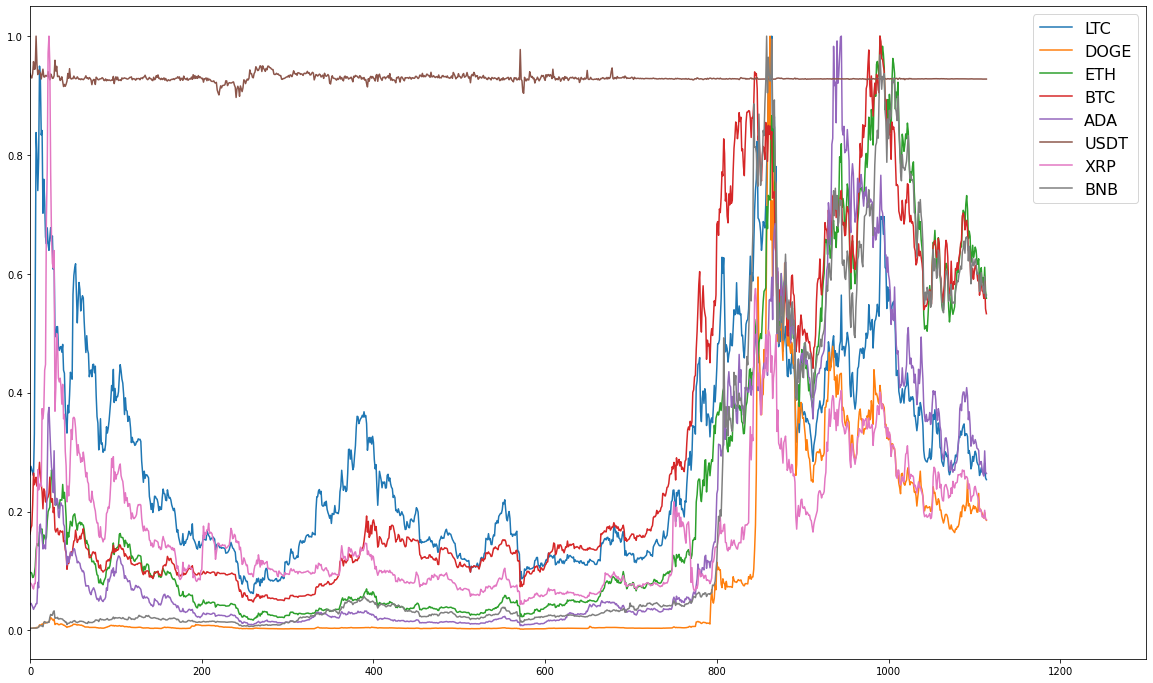

In [32]:
plot_cr = cryptos
cr_names = ["LTC", "DOGE", "ETH", "BTC", "ADA","USDT", "XRP", "BNB"]
print(plot_cr.shape)
plt.figure(figsize=(20,12))
# for i in range(8):
# 	plt.plot(plot_cr[i], label=cr_names[i])
plt.xlim(0, 1300)
plt.plot(plot_cr, label=cr_names)
plt.legend(fontsize=16)
plt.show()